In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Found at: /home/eecs/holly_jackson/dfd/MobileDepth/aligned-focus-stack/Aligned/Figure1/keyboard
Focal depths: [77.931871 71.437225 63.198586 59.38451  50.85456  46.788386 41.009743
 38.761688 33.661801 30.923736 27.687684 25.875741 24.072427 22.488473
 21.261076 19.935908 18.766234 17.926366 16.914894 16.074969 15.415547
 14.848978 14.058852 13.528604 13.111009 12.454026 12.026136 11.503445
 11.097048 10.761507 10.405615 10.      ]
Apertures: 24.694433
Focal length: 2.0
(32, 360, 640, 3)


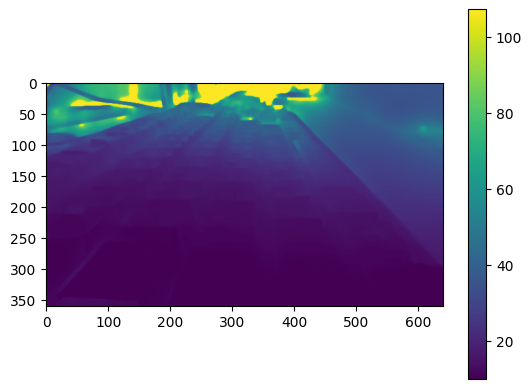

9.944426 107.36895
(32, 180, 320, 3) 11.17454 255.0
Pixel size: 1
32 180 320
float32 float32
Depth range: 7.0 - 80.931871
Dpt result range: 9.944426 - 107.36895


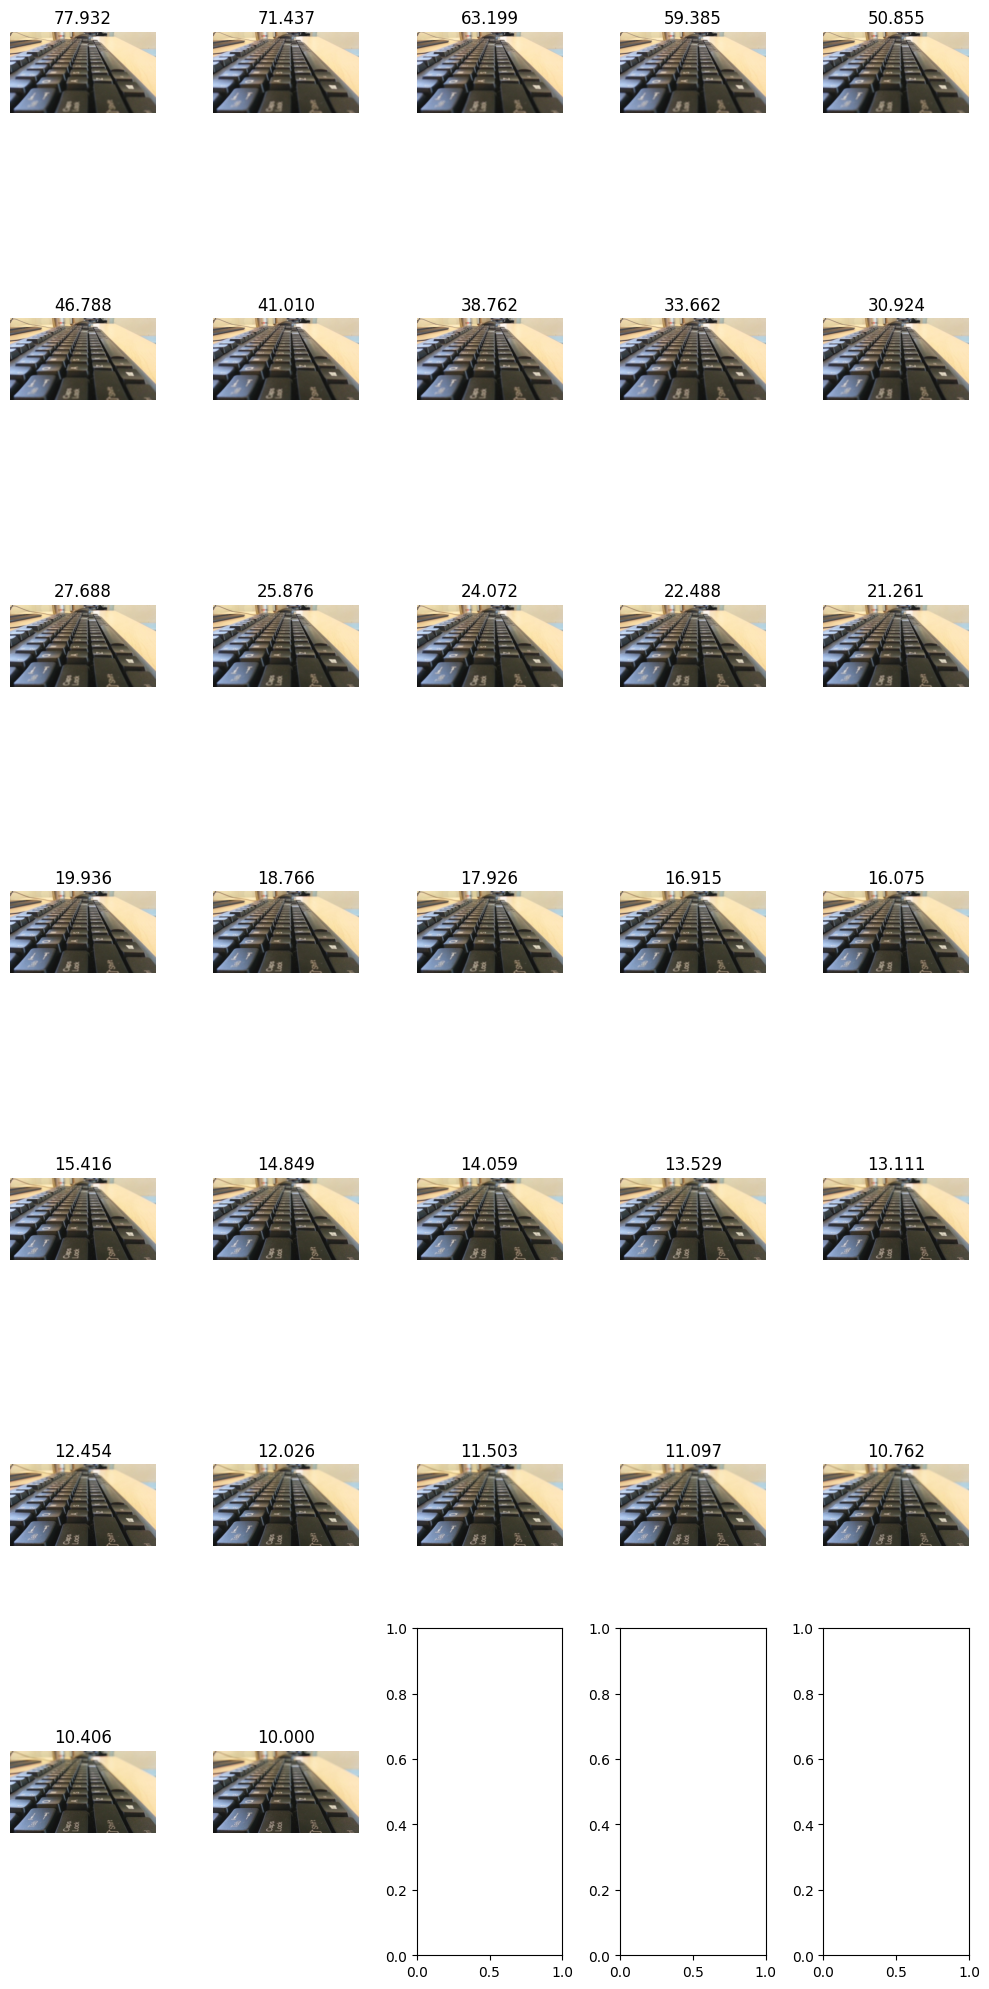

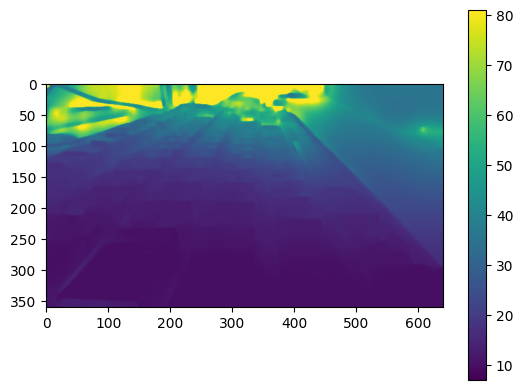

adaptive kernel size set to 11


In [2]:
globals.init_MobileDepth()

IMAGE_RANGE = 255.
example_name = "keyboard"
# ["keyboard", "bottles", "fruits", "metals", "plants", "telephone", "window", "largemotion", "smallmotion", "zeromotion", "balls"]:

defocus_stack, dpt_result, scale_mat = utils.load_single_sample_MobileDepth(example_name)

defocus_stack = np.stack([
    skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=True)
    for img in defocus_stack
], axis=0)

defocus_stack *= IMAGE_RANGE 

print(defocus_stack.shape, defocus_stack.min(), defocus_stack.max())
print('Pixel size:', globals.ps)


fs, width, height, _ = defocus_stack.shape
print(fs, width, height)
print(dpt_result.dtype, defocus_stack.dtype)

globals.min_Z = max(0.1, globals.Df.min() - 3)
globals.max_Z = min(100, globals.Df.max() + 3)
print('Depth range:', globals.min_Z,'-', globals.max_Z)
print('Dpt result range:', dpt_result.min(), '-',dpt_result.max())

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

# plt.imshow(scale_mat)
# plt.colorbar()
# plt.show()

plt.imshow(dpt_result, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

# print(scale_mat.shape)
# print(scale_mat)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)


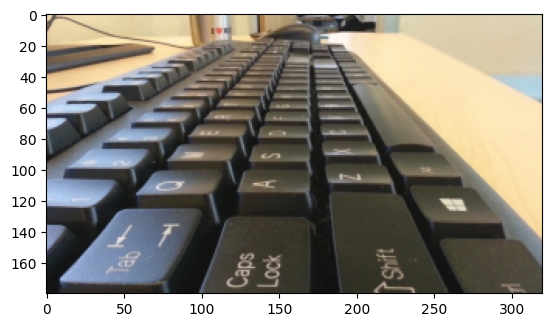

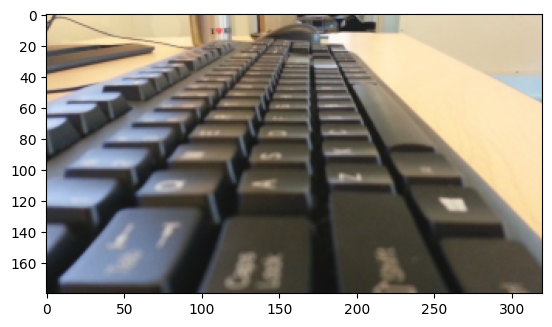

In [3]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

Created experiment folder: /data/holly_jackson/experiments/mobile-depth-keyboard-window5-grid-gss_2025-10-30_15-12-47
Images in range [0-255]


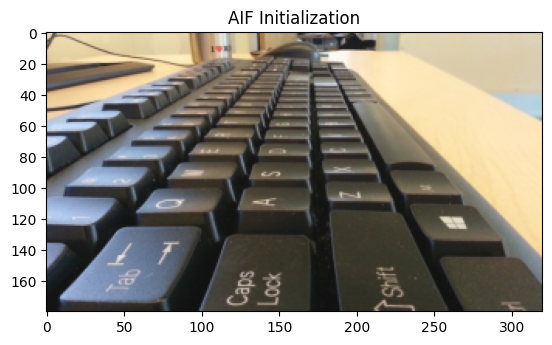

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [01:09<00:00,  1.45it/s]


GRID SEARCH DURATION 69.26230549812317


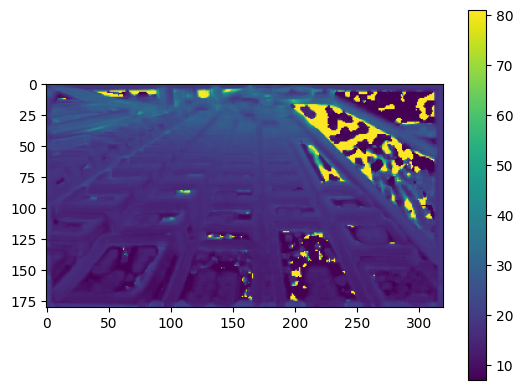


Golden-section search...
...searching for 100 % convergence


In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5
globals.window_size = 5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=True, num_epochs = 1,
        experiment_name = 'mobile-depth-keyboard-window5-grid-gss',
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = globals.min_Z, max_Z = globals.max_Z,
        vmin = globals.min_Z, vmax = globals.max_Z, verbose = True,
        windowed_mse = True)


In [ ]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

In [ ]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [ ]:
aif = aif_init
globals.thresh=0.5


In [ ]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

In [ ]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

In [ ]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])